# Data Preparation Example for Machine Learning

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression


This notebook demonstrates comprehensive data preparation techniques for machine learning.

In [2]:
# Create sample data
data = {
    'car_name': ['car_a', 'car_b', 'car_c', 'car_d', 'car_e', 'car_f'],
    'cylinders': [4, 6, 8, 4, 4, 8],
    'displacement': [140, 200, 360, 150, 130, 3700],
    'horsepower': [90, 105, 215, 92, np.nan, 220],
    'weight': [2400, 3000, 4300, 2500, 2200, 4400],
    'acceleration': [15.5, 14.0, 12.5, 16.0, 15.0, 11.0],
    'model_year': [80, 78, 76, 82, 81, 77],
    'origin': [1, 1, 1, 2, 3, 1],
    'mpg': [30.5, 24.0, 13.0, 29.5, 32.0, 10.0]
}
df = pd.DataFrame(data)
df

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,car_a,4,140,90.0,2400,15.5,80,1,30.5
1,car_b,6,200,105.0,3000,14.0,78,1,24.0
2,car_c,8,360,215.0,4300,12.5,76,1,13.0
3,car_d,4,150,92.0,2500,16.0,82,2,29.5
4,car_e,4,130,NaN,2200,15.0,81,3,32.0
5,car_f,8,3700,220.0,4400,11.0,77,1,10.0


## 1. Handling Missing Values

In [3]:
# 1. Handling Missing Values Example
print("=== Missing Values Before Imputation ===")
print(df.isna().sum())

# Mean imputation
mean_imputer = SimpleImputer(strategy='mean')
df['horsepower_mean'] = mean_imputer.fit_transform(df[['horsepower']])

# Group-based imputation
group_means = df.groupby('cylinders')['horsepower'].transform('mean')
df['horsepower_group'] = df['horsepower'].fillna(group_means)

# KNN imputation
knn_imputer = KNNImputer(n_neighbors=2)
df['horsepower_knn'] = knn_imputer.fit_transform(df[['horsepower']])

print("\n=== After Imputation ===")
df[['horsepower', 'horsepower_mean', 'horsepower_group', 'horsepower_knn']]

=== Missing Values Before Imputation ===
car_name        0
cylinders       0
displacement    0
horsepower      1
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

=== After Imputation ===


,horsepower,horsepower_mean,horsepower_group,horsepower_knn
0,90.0,90.0,90.0,90.0
1,105.0,105.0,105.0,105.0
2,215.0,215.0,215.0,215.0
3,92.0,92.0,92.0,92.0
4,NaN,144.4,91.0,144.4
5,220.0,220.0,220.0,220.0


### What is Imputation?
Imputation is the process of replacing missing data with substituted values. It's crucial because most ML algorithms cannot handle missing values directly.

### Common Imputation Methods:
1. **Mean/Median Imputation**: Replace missing values with the mean or median of the column.
   - Best for: Normally distributed data without outliers
   - When to use: When data is missing completely at random

2. **Group-based Imputation**: Replace missing values with the mean/median of a group
   - Best for: When data has meaningful groups
   - Example: Filling missing horsepower based on car cylinder count

3. **KNN Imputation**: Use k-nearest neighbors to impute missing values
   - Best for: When patterns exist in the data
   - Most accurate but computationally expensive

4. **Arbitrary Value Imputation**: Replace with a value like -999
   - Best for: Tree-based models
   - When to use: When you want to make missing values stand out


Detected 1 outliers in displacement


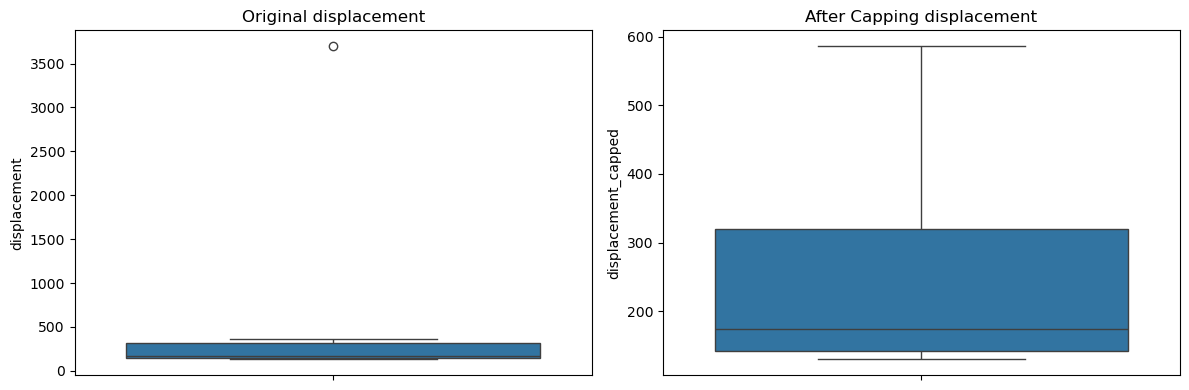

In [4]:
# 2. Handling Outliers Example
def detect_and_handle_outliers(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Detected {len(outliers)} outliers in {column}')

    # Visualize before and after
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[column])
    plt.title(f'Original {column}')

    # Capping outliers
    df[f'{column}_capped'] = np.where(df[column] > upper_bound, upper_bound,
                                     np.where(df[column] < lower_bound, lower_bound, df[column]))

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[f'{column}_capped'])
    plt.title(f'After Capping {column}')

    plt.tight_layout()
    plt.show()

    return df

df = detect_and_handle_outliers(df, 'displacement')

## 2. Handling Outliers

In [5]:
# 3. Feature Scaling Example
# Original data
numeric_cols = ['weight', 'acceleration', 'displacement']
print('Original data:')
print(df[numeric_cols].head())

# Standardization
scaler = StandardScaler()
df_std = df.copy()
df_std[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Min-Max Scaling
minmax = MinMaxScaler()
df_minmax = df.copy()
df_minmax[numeric_cols] = minmax.fit_transform(df[numeric_cols])

print('\nStandardized data (mean=0, std=1):')
print(df_std[numeric_cols].head())

print('Min-Max Scaled data (range [0,1]):')
print(df_minmax[numeric_cols].head())

Original data:
   weight  acceleration  displacement
0    2400          15.5           140
1    3000          14.0           200
2    4300          12.5           360
3    2500          16.0           150
4    2200          15.0           130

Standardized data (mean=0, std=1):
     weight  acceleration  displacement
0 -0.820462      0.854242     -0.489225
1 -0.149175      0.000000     -0.443360
2  1.305280     -0.854242     -0.321054
3 -0.708580      1.138990     -0.481581
4 -1.044224      0.569495     -0.496869
Min-Max Scaled data (range [0,1]):
     weight  acceleration  displacement
0  0.090909           0.9      0.002801
1  0.363636           0.6      0.019608
2  0.954545           0.3      0.064426
3  0.136364           1.0      0.005602
4  0.000000           0.8      0.000000


### What are Outliers?
Outliers are data points significantly different from other observations. They can be caused by measurement errors, data entry errors, or natural variations.

### Impact of Outliers:
- Can skew statistical measures
- May affect model performance
- Can cause models to be overly influenced by extreme values

### Detection Methods:
1. **IQR Method**:
   - Calculate Q1 (25th percentile) and Q3 (75th percentile)
   - IQR = Q3 - Q1
   - Lower bound = Q1 - 1.5*IQR
   - Upper bound = Q3 + 1.5*IQR
   - Points outside these bounds are considered outliers

2. **Z-score Method**:
   - Calculate z-scores: z = (x - mean) / std
   - Points with |z| > 3 are typically considered outliers

### Handling Techniques:
1. **Capping (Winsorization)**: Replace outliers with the nearest non-outlier value
2. **Transformation**: Apply log, square root, or other transformations
3. **Removal**: If outliers are errors or not representative
4. **Separate Modeling**: Create a separate model for outliers


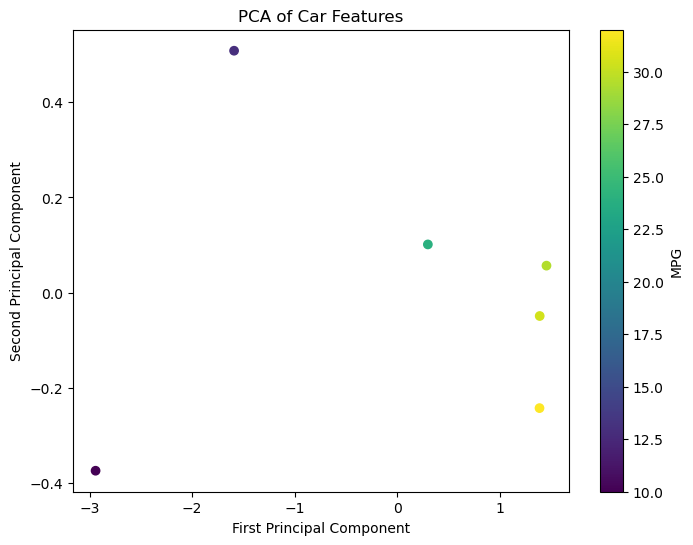

Explained variance ratio: [0.95929265 0.02632386]
Total explained variance: 0.99%


In [6]:
# 4. Dimensionality Reduction Example
# Prepare data for PCA
X = df[['weight', 'acceleration', 'displacement_capped']]
y = df['mpg']

# Standardize the data first
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new dataframe for the principal components
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['mpg'] = y.values

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['mpg'], cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='MPG')
plt.title('PCA of Car Features')
plt.show()

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total explained variance: {sum(pca.explained_variance_ratio_):.2f}%')

## 3. Feature Scaling

In [7]:
# 5. Feature Selection Example
# Prepare data
X = df[['cylinders', 'weight', 'acceleration', 'displacement_capped', 'model_year']]
y = df['mpg']

# Method 1: SelectKBest
selector = SelectKBest(score_func=f_regression, k=3)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print('Top 3 features (SelectKBest):', list(selected_features))

# Method 2: Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=3)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print('Top 3 features (RFE):', list(selected_features_rfe))

Top 3 features (SelectKBest): ['cylinders', 'weight', 'acceleration']
Top 3 features (RFE): ['cylinders', 'acceleration', 'model_year']


### Why Scale Features?
Many machine learning algorithms perform better or converge faster when features are on similar scales.

### Types of Scaling:
1. **Standardization (Z-score Normalization)**
   - Formula: (x - mean) / std
   - Results in mean=0, std=1
   - Best for: Normally distributed features
   - Used in: PCA, LDA, neural networks, SVM with RBF kernel

2. **Min-Max Scaling**
   - Formula: (x - min) / (max - min)
   - Scales features to [0, 1] range
   - Best for: Neural networks, KNN, images
   - Sensitive to outliers

3. **Robust Scaling**
   - Uses median and IQR
   - Formula: (x - median) / IQR
   - Best for: Data with outliers

### When to Scale:
- **Required for**:
  - Distance-based algorithms (KNN, K-means, SVM with RBF kernel)
  - Neural networks
  - Regularized models (Ridge, Lasso)
  - PCA
- **Not needed for**:
  - Tree-based models (Decision Trees, Random Forest, XGBoost)
  - Naive Bayes


## 4. Dimensionality Reduction

### Why Reduce Dimensions?
1. **Curse of Dimensionality**: As dimensions increase, data becomes sparse
2. **Reduces Overfitting**: Fewer features mean fewer parameters to learn
3. **Speeds Up Training**: Less computation required
4. **Improves Visualization**: Easier to visualize 2D or 3D data

### Principal Component Analysis (PCA)
- Projects data onto principal components that maximize variance
- Steps:
  1. Standardize the data
  2. Calculate covariance matrix
  3. Calculate eigenvectors and eigenvalues
  4. Select top k eigenvectors
  5. Transform data to new space

### When to Use:
- When features are correlated
- For visualization
- Before training models with many features
- For noise reduction


## 5. Feature Selection

### Why Select Features?
1. **Reduces Overfitting**: Less redundant data means less chance for noise
2. **Improves Accuracy**: Removes misleading data
3. **Reduces Training Time**: Fewer features mean faster training
4. **Improves Interpretability**: Easier to understand the model

### Methods:
1. **Filter Methods**:
   - Select features based on statistical tests
   - Example: Correlation coefficient, Chi-square test
   - Fast but doesn't consider feature interactions

2. **Wrapper Methods**:
   - Use a subset of features and train a model
   - Example: Recursive Feature Elimination (RFE)
   - Computationally expensive but more accurate

3. **Embedded Methods**:
   - Feature selection as part of the model training process
   - Example: Lasso regression, Decision trees
   - Efficient and accurate but model-specific
